In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from lib.util.helper import query_table, weekday_time_series
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.preprocessing import StandardScaler

In [11]:
druck_5T = weekday_time_series(sensor_id='xl106_druckmaschine_5T')

In [12]:
druck_5T['kw'] = round(druck_5T['kw'], 2)

In [81]:
px.line(
    x=druck_5T.index, y=druck_5T.kw, 
    title='UV Sigma Line',
    labels={
        'x': 'Time',
        'y': 'kW'
    },
    markers=False)

In [14]:
druck = druck_5T[(druck_5T.index.day > 10) & (druck_5T.index.day <= 15)] ## for pedagoical reasons
day_range = druck.index.max() - druck.index.min()

In [25]:
druck_final = pd.DataFrame(data=druck['kw'], index=druck.index)
#druck_final['hour'] = druck_final.index.hour
druck_final.reset_index(inplace=True)

# Scaling helps with convergence via MCMC
scale = StandardScaler()
druck_final['kw'] = scale.fit_transform(druck_final['kw'].values.reshape(-1, 1))

#druck_test = druck_line[druck_line.index.day >= 17]
#druck_test_final = pd.DataFrame(data=druck_test['kw'], index=druck_test.index)

In [33]:
druck_final = druck_final.rename(columns={'t': 'ds', 'kw': 'y'})
druck_final['floor'] = -1
druck_final['cap'] = 3

In [17]:
def machine_off(ds):
    date = pd.to_datetime(ds)
    if ds.hour >= 22 or ds.hour <= 6:
        return 1
    else:
        return 0

In [12]:
#druck_final['machine_state'] = druck_final['ds'].apply(machine_off)
#druck_final['machine_state'] = ~druck_final['ds'].apply(machine_off)
#druck_final

In [75]:
m = Prophet(
    changepoint_prior_scale=10.0,
    growth='logistic',
    #n_changepoints=50
    
)

# Add custom seasonality which isn't pre-built
m.add_seasonality(name='hourly', period=0.041, fourier_order=30) ## higher order captures how "quickly" the seasonality can change
#m.add_regressor(name='machine_state') 
#m.add_seasonality(name='daily', period=1, fourier_order=5)

m.fit(druck_final)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -187.312


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1897.03    0.00060032       66.1313      0.4032      0.4032      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1897.97    0.00250416       21.5893           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1912.72     0.0174648       267.834      0.8069      0.8069      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1914.52    0.00649701       19.6249           1           1      550   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1915.67     0.0068199       146.392     0.01794           1      684   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [80]:
future = pd.DataFrame(
    data=pd.date_range('2021-10-11 00:00:00', '2021-10-15 23:50:00', freq='5T'),
    columns=['ds']
    )
    
#future['machine_state'] = future['hour'].apply(lambda x: 1 if x >= 0 and x <= 6 else 0)

future['floor'] = -1
future['cap'] = 3

In [77]:
forecast = m.predict(future)

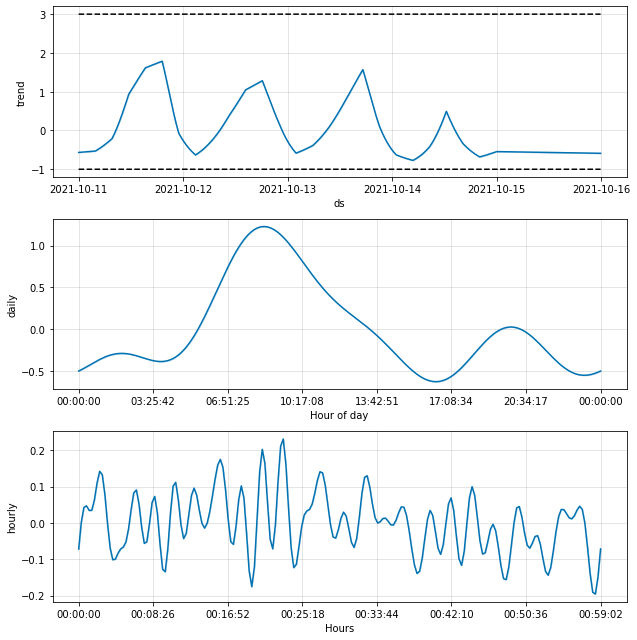

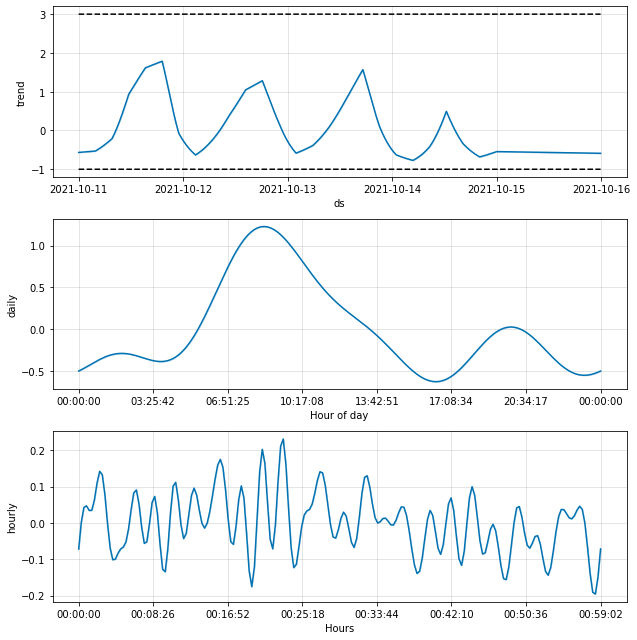

In [78]:
m.plot_components(forecast)

In [79]:
import plotly
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)